In [ ]:

!pip -q install git+https://github.com/openai/CLIP.git torch torchvision --upgrade

import os, io, re
import numpy as np
import torch, clip
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_NAME = "ViT-B/32"
model, preprocess = clip.load(MODEL_NAME, device=device)
logit_scale = model.logit_scale.exp().detach().cpu().item()

TEMP = 1.2
DECISION_MODE = "max"
TOPK_SHOW = 3

TEMPLATES = [
    "close-up of a hand, {}",
    "a photo of a hand, {}",
    "a detailed photo of a hand, {}",
    "macro photo of a hand, {}",
    "clinical photo of a hand, {}",
]

FIST_PHRASES = [
    "fist",
    "hand closed in a fist",
    "fingers curled",
    "knuckles visible",
    "closed hand",
]

OPEN_PHRASES = [
    "open",
    "open hand",
    "hand open",
    "fingers extended",
    "palm visible",
]

def build_prompts(phrases):
    out = []
    for ph in phrases:
        for t in TEMPLATES:
            out.append(t.format(ph))
    seen = set(); uniq = []
    for s in out:
        k = s.lower().strip()
        if k not in seen:
            uniq.append(s); seen.add(k)
    return uniq

PROMPTS_FIST = build_prompts(FIST_PHRASES)
PROMPTS_OPEN = build_prompts(OPEN_PHRASES)

@torch.no_grad()
def encode_texts(texts):
    toks = clip.tokenize(texts, truncate=True).to(device)
    feats = model.encode_text(toks)
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats

text_fist = encode_texts(PROMPTS_FIST)
text_open = encode_texts(PROMPTS_OPEN)

text_fist_mean = text_fist.mean(dim=0); text_fist_mean /= text_fist_mean.norm()
text_open_mean = text_open.mean(dim=0); text_open_mean /= text_open_mean.norm()

@torch.no_grad()
def embed_image(pil_img):
    x = preprocess(pil_img).unsqueeze(0).to(device)
    f = model.encode_image(x)
    f = f / f.norm(dim=-1, keepdim=True)
    return f.squeeze(0)

@torch.no_grad()
def decide_with_buckets(img_feat, mode="max", temp=1.2):
    if mode in ("max", "mean_prob"):
        logits_fist = (img_feat @ text_fist.T) * logit_scale / temp
        logits_open = (img_feat @ text_open.T) * logit_scale / temp
        logits_all = torch.cat([logits_fist, logits_open], dim=0)

        probs_all = logits_all.softmax(dim=-1).detach().cpu().numpy()
        probs_fist = probs_all[:len(PROMPTS_FIST)]
        probs_open = probs_all[len(PROMPTS_FIST):]

        if mode == "max":
            score_fist = float(probs_fist.max())
            score_open = float(probs_open.max())
        else:
            score_fist = float(probs_fist.mean())
            score_open = float(probs_open.mean())

        pred = "ÖKÖLBE SZORÍTVA" if score_fist > score_open else "NINCS ÖKÖLBE SZORÍTVA"
        conf = max(score_fist, score_open)

        topk_f_idx = probs_fist.argsort()[::-1][:TOPK_SHOW]
        topk_o_idx = probs_open.argsort()[::-1][:TOPK_SHOW]
        dbg = {
            "top_fist": [(PROMPTS_FIST[i], float(probs_fist[i])) for i in topk_f_idx],
            "top_open": [(PROMPTS_OPEN[i], float(probs_open[i])) for i in topk_o_idx],
            "score_fist": score_fist, "score_open": score_open
        }
        return pred, conf, dbg

    elif mode == "mean_feat":
        logits2 = torch.stack([
            (img_feat @ text_fist_mean) * logit_scale / temp,
            (img_feat @ text_open_mean) * logit_scale / temp
        ], dim=0)
        probs2 = logits2.softmax(dim=-1).detach().cpu().numpy()
        score_fist, score_open = float(probs2[0]), float(probs2[1])
        pred = "ÖKÖLBE SZORÍTVA" if score_fist > score_open else "NINCS ÖKÖLBE SZORÍTVA"
        conf = max(score_fist, score_open)
        dbg = {
            "top_fist": [("mean_feat (bucket avg)", score_fist)],
            "top_open": [("mean_feat (bucket avg)", score_open)],
            "score_fist": score_fist, "score_open": score_open
        }
        return pred, conf, dbg

    else:
        raise ValueError("DECISION_MODE csak: 'max', 'mean_prob', 'mean_feat' lehet.")


  Preparing metadata (setup.py) ... done


Válassz ki egy vagy több képet (pl. .jpg, .png).


Saving kérdéses.jfif to kérdéses (3).jfif
Saving nyitott.jfif to nyitott (3).jfif
Saving nyitott2.jfif to nyitott2 (4).jfif
Saving nyitott3.jfif to nyitott3 (3).jfif
Saving nyitott4.jfif to nyitott4.jfif
Saving nyitott5.jfif to nyitott5.jfif
Saving nyitott6.jfif to nyitott6.jfif
Saving nyitott7.jfif to nyitott7.jfif
Saving ököl.jfif to ököl (3).jfif
Saving ököl2.jfif to ököl2 (3).jfif
Saving ököl3.htm to ököl3 (3).htm
Saving ököl4.jfif to ököl4 (3).jfif
Saving ököl5.jfif to ököl5.jfif
Saving ököl6.jfif to ököl6.jfif
Saving ököl7.jfif to ököl7.jfif


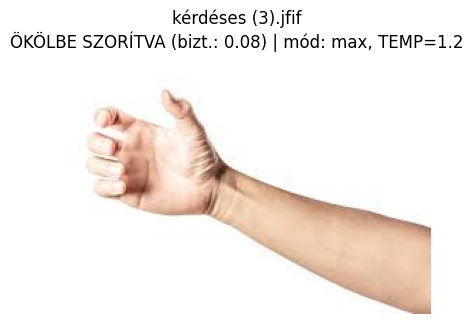

FIST – TOP sorok:
  0.083  |  a photo of a hand, hand closed in a fist
  0.076  |  a detailed photo of a hand, hand closed in a fist
  0.066  |  clinical photo of a hand, hand closed in a fist
OPEN – TOP sorok:
  0.042  |  a photo of a hand, fingers extended
  0.038  |  a photo of a hand, hand open
  0.035  |  clinical photo of a hand, hand open
------------------------------------------------------------


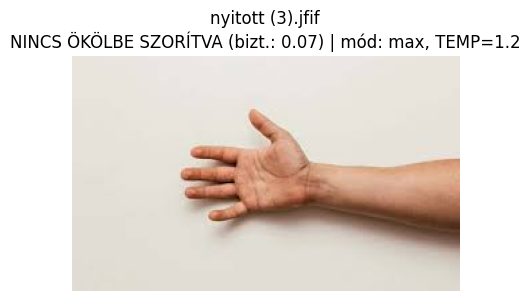

FIST – TOP sorok:
  0.061  |  a photo of a hand, closed hand
  0.050  |  a photo of a hand, hand closed in a fist
  0.040  |  a photo of a hand, knuckles visible
OPEN – TOP sorok:
  0.066  |  a photo of a hand, hand open
  0.064  |  a photo of a hand, fingers extended
  0.042  |  a photo of a hand, open hand
------------------------------------------------------------


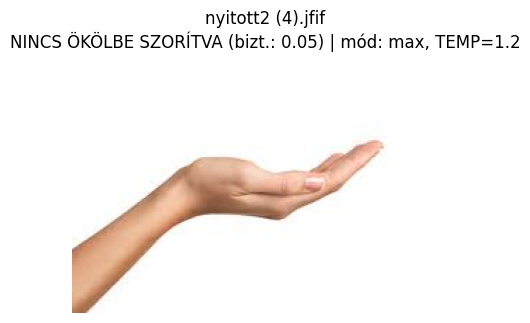

FIST – TOP sorok:
  0.043  |  a photo of a hand, closed hand
  0.037  |  a photo of a hand, hand closed in a fist
  0.037  |  a detailed photo of a hand, closed hand
OPEN – TOP sorok:
  0.053  |  a photo of a hand, open hand
  0.050  |  a photo of a hand, hand open
  0.050  |  a detailed photo of a hand, open hand
------------------------------------------------------------


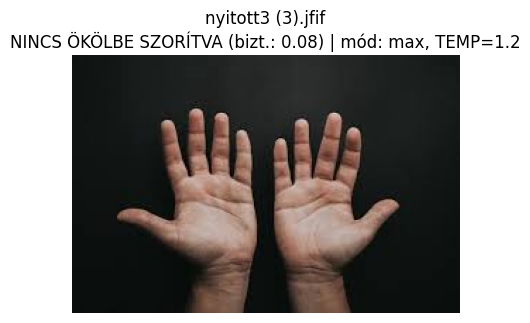

FIST – TOP sorok:
  0.062  |  a photo of a hand, closed hand
  0.044  |  a photo of a hand, hand closed in a fist
  0.036  |  a photo of a hand, fist
OPEN – TOP sorok:
  0.083  |  a photo of a hand, fingers extended
  0.056  |  a photo of a hand, open hand
  0.045  |  a photo of a hand, hand open
------------------------------------------------------------


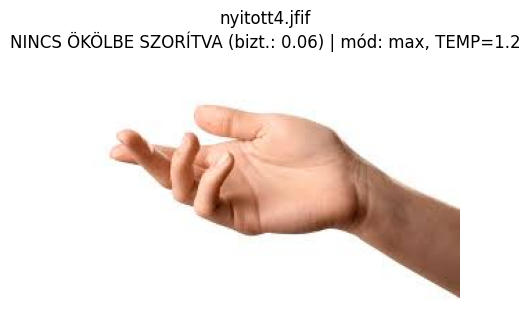

FIST – TOP sorok:
  0.053  |  a photo of a hand, hand closed in a fist
  0.048  |  a detailed photo of a hand, hand closed in a fist
  0.045  |  clinical photo of a hand, hand closed in a fist
OPEN – TOP sorok:
  0.057  |  a photo of a hand, fingers extended
  0.036  |  a photo of a hand, hand open
  0.033  |  a photo of a hand, palm visible
------------------------------------------------------------


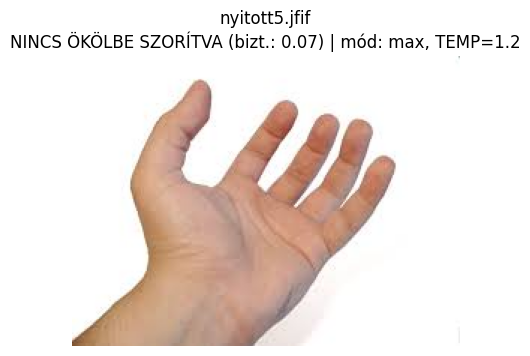

FIST – TOP sorok:
  0.052  |  a photo of a hand, knuckles visible
  0.045  |  clinical photo of a hand, fist
  0.045  |  a photo of a hand, fist
OPEN – TOP sorok:
  0.072  |  a photo of a hand, fingers extended
  0.049  |  a photo of a hand, palm visible
  0.036  |  clinical photo of a hand, fingers extended
------------------------------------------------------------


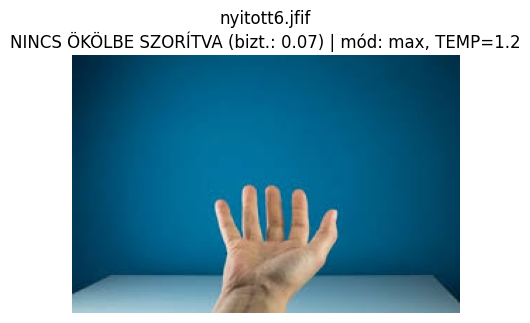

FIST – TOP sorok:
  0.052  |  clinical photo of a hand, hand closed in a fist
  0.046  |  a photo of a hand, closed hand
  0.045  |  a photo of a hand, hand closed in a fist
OPEN – TOP sorok:
  0.075  |  a photo of a hand, fingers extended
  0.048  |  a photo of a hand, hand open
  0.041  |  clinical photo of a hand, hand open
------------------------------------------------------------


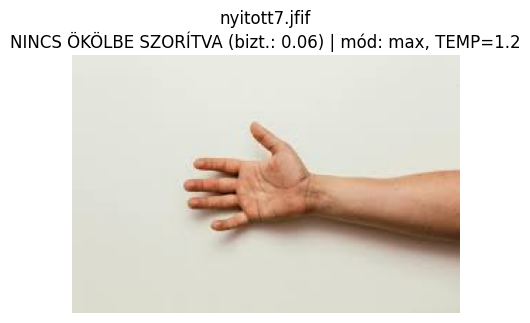

FIST – TOP sorok:
  0.050  |  a photo of a hand, closed hand
  0.039  |  a photo of a hand, knuckles visible
  0.039  |  a photo of a hand, hand closed in a fist
OPEN – TOP sorok:
  0.056  |  a photo of a hand, fingers extended
  0.051  |  a photo of a hand, hand open
  0.037  |  a photo of a hand, palm visible
------------------------------------------------------------


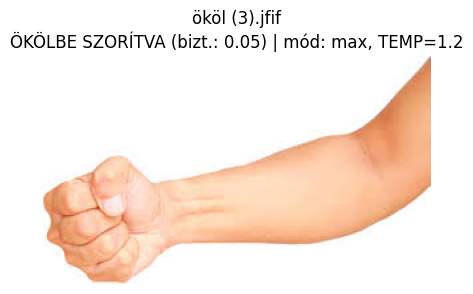

FIST – TOP sorok:
  0.049  |  a detailed photo of a hand, hand closed in a fist
  0.048  |  clinical photo of a hand, hand closed in a fist
  0.040  |  a photo of a hand, hand closed in a fist
OPEN – TOP sorok:
  0.045  |  a photo of a hand, fingers extended
  0.040  |  clinical photo of a hand, fingers extended
  0.040  |  clinical photo of a hand, hand open
------------------------------------------------------------


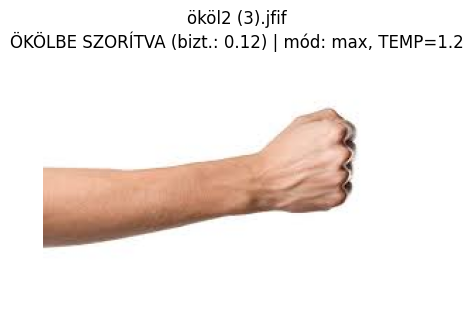

FIST – TOP sorok:
  0.115  |  a photo of a hand, fist
  0.088  |  a detailed photo of a hand, fist
  0.066  |  a photo of a hand, hand closed in a fist
OPEN – TOP sorok:
  0.049  |  a photo of a hand, hand open
  0.048  |  a photo of a hand, fingers extended
  0.033  |  a photo of a hand, palm visible
------------------------------------------------------------
Hiba a ököl3 (3).htm megnyitásakor: cannot identify image file <_io.BytesIO object at 0x7e62f423fd80>


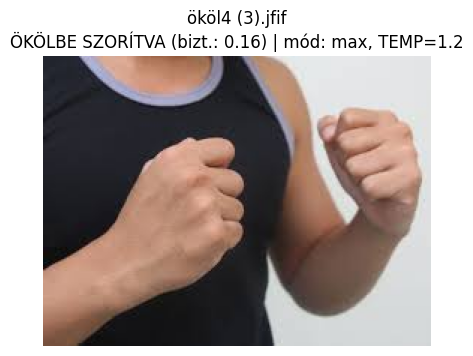

FIST – TOP sorok:
  0.158  |  clinical photo of a hand, hand closed in a fist
  0.106  |  a detailed photo of a hand, hand closed in a fist
  0.105  |  a photo of a hand, hand closed in a fist
OPEN – TOP sorok:
  0.039  |  clinical photo of a hand, fingers extended
  0.023  |  a photo of a hand, fingers extended
  0.021  |  clinical photo of a hand, open hand
------------------------------------------------------------


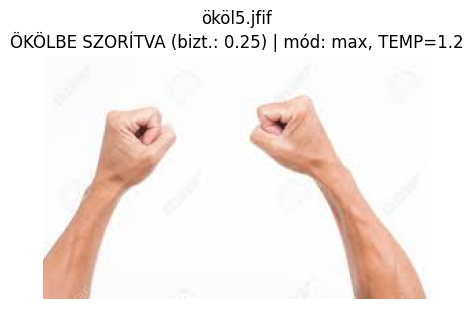

FIST – TOP sorok:
  0.246  |  a photo of a hand, hand closed in a fist
  0.149  |  a photo of a hand, fist
  0.143  |  a detailed photo of a hand, hand closed in a fist
OPEN – TOP sorok:
  0.019  |  a photo of a hand, hand open
  0.018  |  a photo of a hand, fingers extended
  0.012  |  a photo of a hand, open hand
------------------------------------------------------------


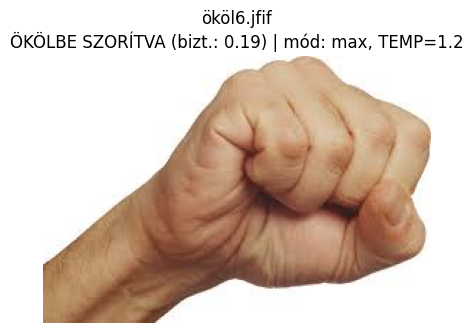

FIST – TOP sorok:
  0.194  |  a photo of a hand, hand closed in a fist
  0.162  |  a detailed photo of a hand, hand closed in a fist
  0.095  |  a photo of a hand, fist
OPEN – TOP sorok:
  0.016  |  a photo of a hand, open hand
  0.014  |  a photo of a hand, fingers extended
  0.011  |  a detailed photo of a hand, open hand
------------------------------------------------------------


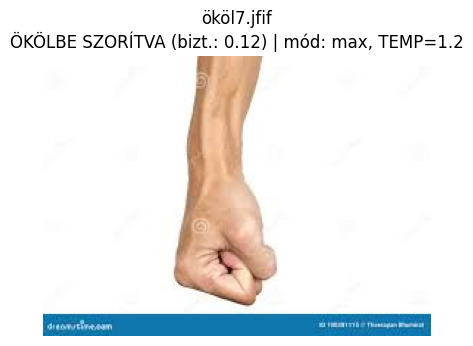

FIST – TOP sorok:
  0.118  |  a photo of a hand, fist
  0.104  |  a detailed photo of a hand, fist
  0.087  |  a photo of a hand, hand closed in a fist
OPEN – TOP sorok:
  0.053  |  a photo of a hand, hand open
  0.039  |  a photo of a hand, fingers extended
  0.039  |  a photo of a hand, open hand
------------------------------------------------------------


,fájl,predikció,biztonság,score_fist,score_open,mód,TEMP
11,ököl5.jfif,ÖKÖLBE SZORÍTVA,0.246193,0.246193,0.018558,max,1.2
12,ököl6.jfif,ÖKÖLBE SZORÍTVA,0.193868,0.193868,0.016222,max,1.2
10,ököl4 (3).jfif,ÖKÖLBE SZORÍTVA,0.157769,0.157769,0.039098,max,1.2
13,ököl7.jfif,ÖKÖLBE SZORÍTVA,0.117718,0.117718,0.052664,max,1.2
9,ököl2 (3).jfif,ÖKÖLBE SZORÍTVA,0.115455,0.115455,0.048755,max,1.2
0,kérdéses (3).jfif,ÖKÖLBE SZORÍTVA,0.082900,0.082900,0.041758,max,1.2
3,nyitott3 (3).jfif,NINCS ÖKÖLBE SZORÍTVA,0.082552,0.062290,0.082552,max,1.2
6,nyitott6.jfif,NINCS ÖKÖLBE SZORÍTVA,0.074626,0.051655,0.074626,max,1.2
5,nyitott5.jfif,NINCS ÖKÖLBE SZORÍTVA,0.072090,0.052312,0.072090,max,1.2
1,nyitott (3).jfif,NINCS ÖKÖLBE SZORÍTVA,0.065774,0.060671,0.065774,max,1.2


In [ ]:

print("Válassz ki egy vagy több képet (pl. .jpg, .png).")
uploaded = files.upload()
os.makedirs("test_images", exist_ok=True)

rows = []
for fname, data in uploaded.items():
    path = os.path.join("test_images", fname)
    with open(path, "wb") as f: f.write(data)

    try:
        img = Image.open(io.BytesIO(data)).convert("RGB")
    except Exception as e:
        print(f"Hiba a {fname} megnyitásakor: {e}")
        continue

    img_feat = embed_image(img)
    pred, conf, dbg = decide_with_buckets(img_feat, mode=DECISION_MODE, temp=TEMP)

    plt.figure(figsize=(5,5))
    plt.imshow(img); plt.axis('off')
    plt.title(f"{fname}\n{pred} (bizt.: {conf:.2f}) | mód: {DECISION_MODE}, TEMP={TEMP}")
    plt.show()

    print("FIST – TOP sorok:")
    for s, p in dbg["top_fist"]:
        print(f"  {p:5.3f}  |  {s}")
    print("OPEN – TOP sorok:")
    for s, p in dbg["top_open"]:
        print(f"  {p:5.3f}  |  {s}")
    print("-"*60)

    rows.append({
        "fájl": fname,
        "predikció": pred,
        "biztonság": conf,
        "score_fist": dbg["score_fist"],
        "score_open": dbg["score_open"],
        "mód": DECISION_MODE,
        "TEMP": TEMP
    })

if rows:
    df = pd.DataFrame(rows).sort_values(by="biztonság", ascending=False)
    from IPython.display import display
    display(df)
else:
    print("Nem sikerült kiértékelni a képeket.")
